In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from pandas import get_dummies

In [18]:
df = pd.read_csv('../Resources/vg_sales.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


**TOP VALUES**

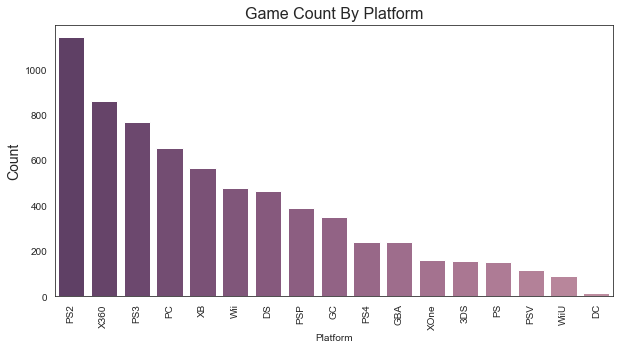

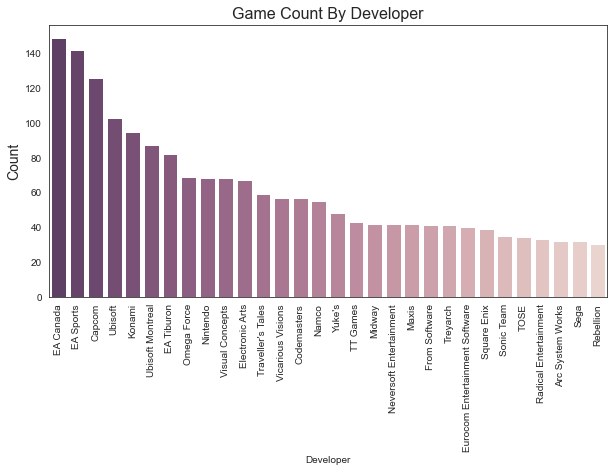

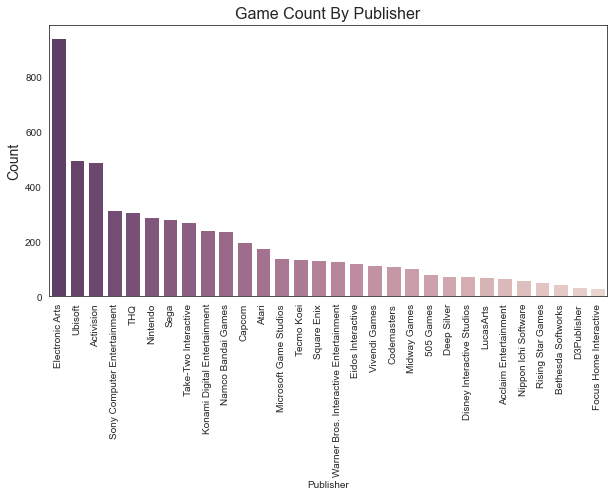

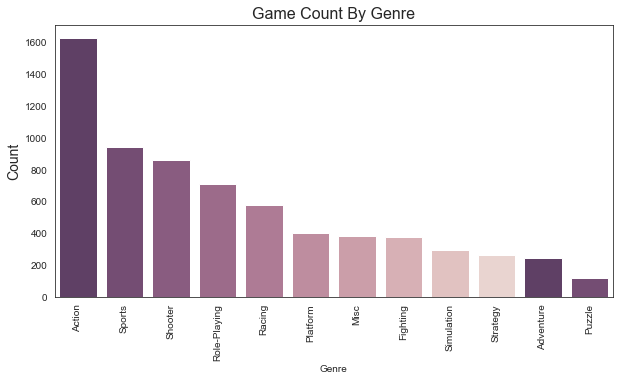

In [49]:
cols = ['Platform', 'Developer', 'Publisher', 'Genre']

for col in cols:
    chart = df[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()
    sns.set_style("white")
    plt.figure(figsize=(10, 5))
    plt.xticks(rotation=90)
    sns.barplot(x=col, y='Name', data=chart[:30], palette=sns.cubehelix_palette((10 if col == 'Genre' else 30), dark=0.3, light=.85, reverse=True)).set_title(('Game Count By '+col), fontsize=16)
    plt.ylabel('Count', fontsize=14)

**SALES vs CRITIC SCORES**

In [20]:
# Defining score groups for additional column

def score_group(score):
    if score >= 90:
        return '90-100'
    elif score >= 80:
        return '80-89'
    elif score >= 70:
        return '70-79'
    elif score >= 60:
        return '60-69'
    elif score >= 50:
        return '50-59'
    else:
        return '0-49'

In [21]:
# Adding score group column to DataFrame

df_score = df.dropna(subset=['Critic_Score']).reset_index(drop=True)
df_score['Score_Group'] = df_score['Critic_Score'].apply(lambda x: score_group(x))
df_score.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Score_Group
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,70-79
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,80-89
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,80-89
3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E,80-89
4,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E,50-59


[(0.0, 17.5)]

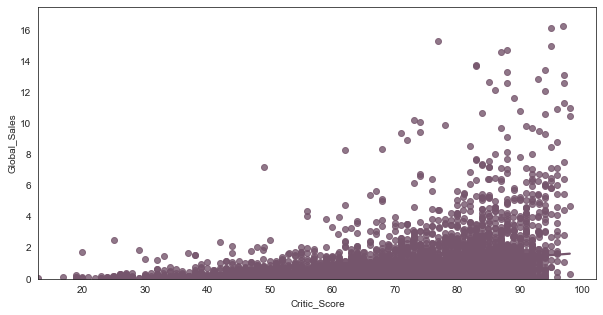

In [22]:
# Plotting critic score versus global sales to see what kind of correlation there may be

fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df_score, ci=None, color="#75556c", x_jitter=.02).set(ylim=(0, 17.5))

[(0.0, 4.0), (50.0, 95.0)]

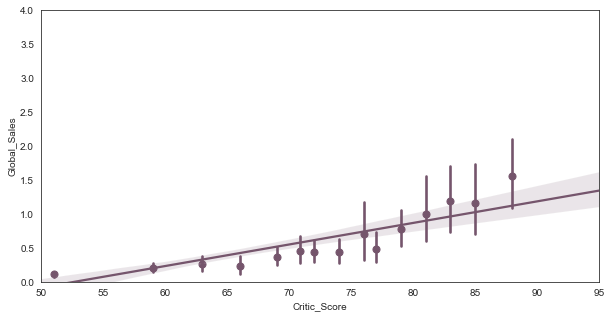

In [23]:
# Replotting to critic score versus global sales to get a better visual for the correlation

fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df_score.loc[df_score.Year_of_Release >= 2014], truncate=True, x_bins=15, color="#75556c").set(ylim=(0, 4), xlim=(50, 95))

**DEFINING A GAME AS A "HIT"**

In [24]:
# Defining a game as a "hit" to use for future ML models

df_hit = df[['Name','Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]

df_hit = df_hit.dropna().reset_index(drop=True)

df2 = df_hit[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]

df2['Hit'] = df2['Global_Sales']

df2.drop('Global_Sales', axis=1, inplace=True)

In [25]:
# Returning a table that now has a "hit" column

def hit(sales):

    if sales >= 1:
        return 1
    else:
        return 0

df2['Hit'] = df2['Hit'].apply(lambda x: hit(x))

df2.head()

,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Hit
0,Wii,Sports,Nintendo,2006.0,76.0,1
1,Wii,Racing,Nintendo,2008.0,82.0,1
2,Wii,Sports,Nintendo,2009.0,80.0,1
3,DS,Platform,Nintendo,2006.0,89.0,1
4,Wii,Misc,Nintendo,2006.0,58.0,1


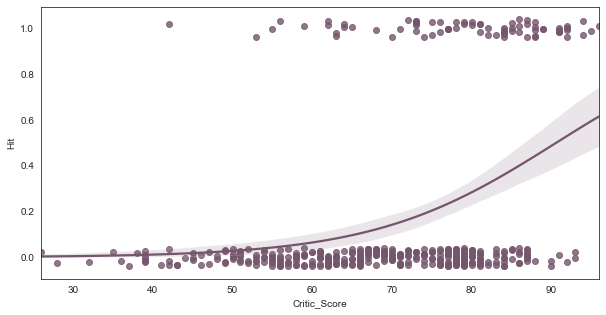

In [26]:
# Plotting a logistic regression graph to represent sample data using 5% of the data

n = ceil(0.05 * len(df2['Hit']))

fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.regplot(x="Critic_Score", y="Hit", data=df2.sample(n=n), logistic=True, n_boot=500, y_jitter=.04, color="#75556c")

**LOGISTIC REGRESSION & RANDOM FOREST CLASSIFIER MODEL**

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [31]:
# Visualize the DataFrame to be used in the model

df2.head()

,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Hit
0,Wii,Sports,Nintendo,2006.0,76.0,1
1,Wii,Racing,Nintendo,2008.0,82.0,1
2,Wii,Sports,Nintendo,2009.0,80.0,1
3,DS,Platform,Nintendo,2006.0,89.0,1
4,Wii,Misc,Nintendo,2006.0,58.0,1


In [32]:
df_copy = pd.get_dummies(df2)

In [33]:
df_copy.head()

,Year_of_Release,Critic_Score,Hit,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Publisher_Xplosiv,Publisher_Xseed Games,Publisher_Yacht Club Games,Publisher_Yuke's,Publisher_Zoo Digital Publishing,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_id Software,Publisher_inXile Entertainment
0,2006.0,76.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2008.0,82.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2009.0,80.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2006.0,89.0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006.0,58.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df3 = df_copy
y = df3['Hit'].values
df3 = df3.drop(['Hit'],axis=1)
X = df3.values

In [35]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)

In [36]:
radm = RandomForestClassifier(random_state=42).fit(Xtrain, ytrain)
y_val_1 = radm.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values == ytest)/len(ytest))

Validation accuracy:  0.8562124248496994


In [37]:
log_reg = LogisticRegression().fit(Xtrain, ytrain)
y_val_2 = log_reg.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values == ytest)/len(ytest))

Validation accuracy:  0.8602204408817635


C:\Users\cpres\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [38]:
all_predictions = log_reg.predict(Xtest)
print(classification_report(ytest, all_predictions))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1644
           1       0.71      0.36      0.47       352

    accuracy                           0.86      1996
   macro avg       0.79      0.66      0.70      1996
weighted avg       0.85      0.86      0.84      1996



**LINEAR REGRESSION**